# Documentation

This notebook was inspired from: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Evaluating_DETR_on_COCO_validation_2017.ipynb

In this Notebook we will evaluate the performance of an already fine tuned DETR model named `TahaDouaji/detr-doc-table-detection` on our annotated datsaset. In order to do this we need to export again our dataset from CVAT platform as the DETR model needs COCO format for the annotations.

# Installing Libraries

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm
!pip install -q coco_eval

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 req

# Setting Working Directory

In [ ]:
import os

# set the working directory (this version is creted for Google Colab)
my_wd = "/content"
os.chdir(my_wd)
print("Changed working directory to:", os.getcwd())

Changed working directory to: /content


# Mounting Google Drive

In [ ]:
from google.colab import drive

# mount google drive
drive.mount(os.path.join(my_wd,"drive"))

Mounted at /content/drive


# Downloading Annotations in COCO Format

We navigate to the task section and we click the 3 bullets on the corresponding task as the image below

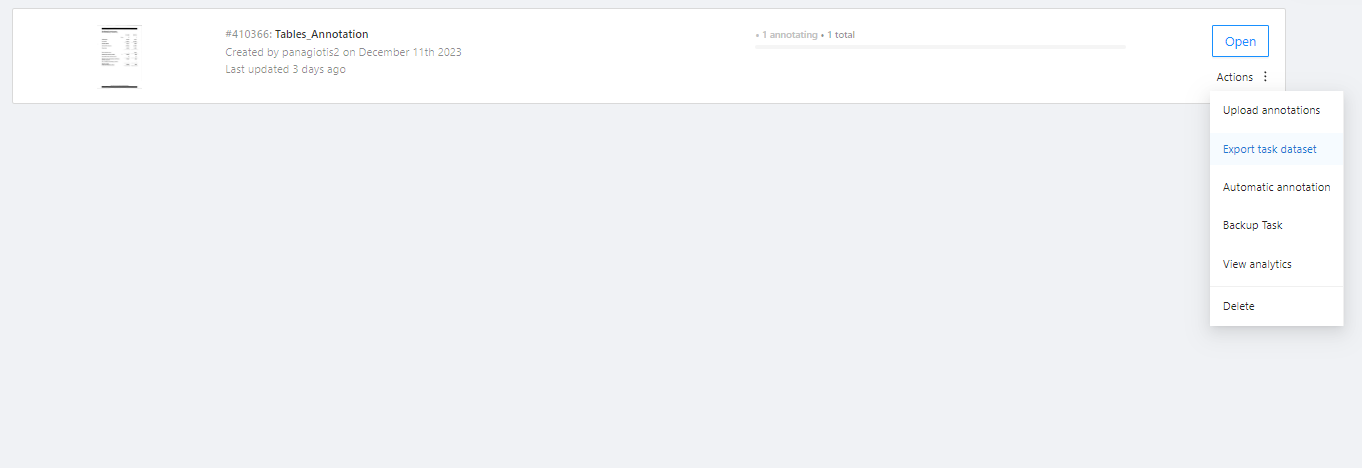

In [ ]:
from IPython.display import Image, display

# define the google drive location
file_name = "drive/MyDrive/Capstone Project/My Capstone/Table Detection and Extraction/Experiments Results/Step 2_Already Fine Tuned Models Approach/Images From Annotation Process (COCO Format)/Capture.PNG"

# create the final path
file_name = os.path.join(my_wd, file_name)

# display the image
display(Image(filename=file_name))

We choose COCO 1.0 Format

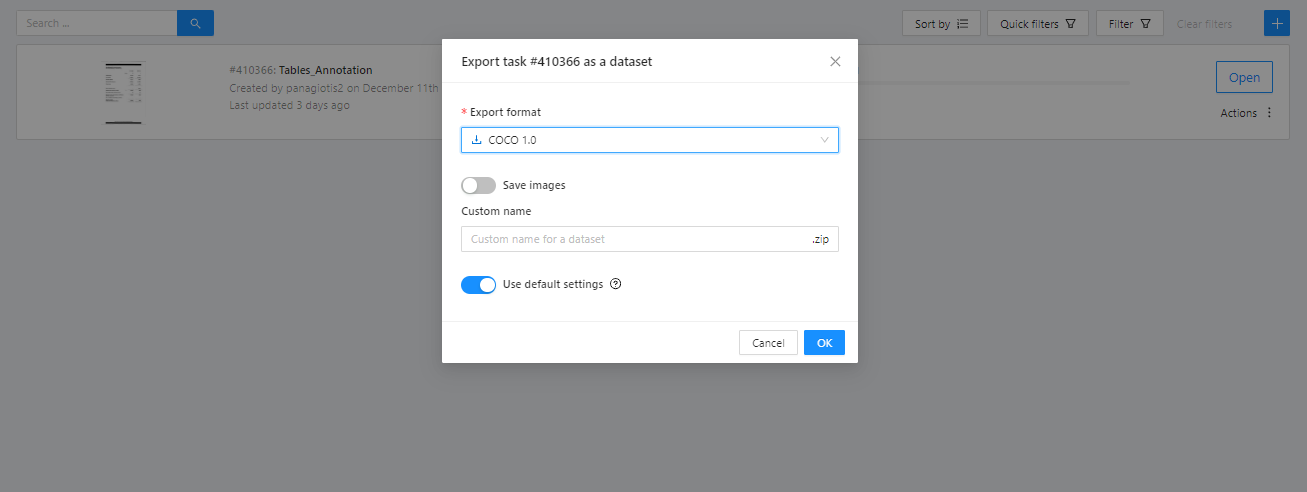

In [ ]:
from IPython.display import Image, display

# define the google drive location
file_name = "drive/MyDrive/Capstone Project/My Capstone/Table Detection and Extraction/Experiments Results/Step 2_Already Fine Tuned Models Approach/Images From Annotation Process (COCO Format)/Capture2.PNG"

# create the final path
file_name = os.path.join(my_wd, file_name)

# display the image
display(Image(filename=file_name))

After this the file need to be uploaded to Google Drive

# Loading and Unzipping the `Final Tables Dataset` to our Working Directory

In [ ]:
# define the google drive location
drive_location = "drive/MyDrive/Capstone Project/My Capstone/Datasets/Tables/Final Tables Dataset.zip"

# create the final path
zip_file_path = os.path.join(my_wd, drive_location)

# keep the name of the zipped folder
zip_basename = os.path.splitext(os.path.basename(drive_location))[0]

# unzip the folder
!unzip -q "{zip_file_path}" -d "{zip_basename}"

# Train, Test, Val Sets Split | Random State 42

To evaluate the model on the test dataset, we need to split it first. Since DETR also requires a strict format for annotations, each folder for train, test, and validation should have its own JSON file containing the corresponding annotations. The following code accomplishes this task.

In [ ]:
import os
import json
import shutil
from sklearn.model_selection import train_test_split

# define the source path
source_path = "drive/MyDrive/Capstone Project/My Capstone/Table Detection and Extraction/Experiments Results/Step 2_Already Fine Tuned Models Approach/annotations_in_coco_format.json"
source_path = os.path.join(my_wd, source_path)

# Load the original JSON file
with open(source_path, 'r') as f:
    original_data = json.load(f)

# Extract filenames and image data
filenames = [img['file_name'] for img in original_data['images']]
image_data = original_data['images']


# Split the dataset into training, validation, and test sets for images
train_files, test_val_files = train_test_split(filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

# Create folders for train, validation, and test sets
os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
os.makedirs('test', exist_ok=True)

# Copy images to corresponding folders
for filename in train_files:
    shutil.copy(os.path.join(my_wd,'Final Tables Dataset/Final Tables Dataset/Final Tables Dataset', filename), 'train')

for filename in val_files:
    shutil.copy(os.path.join(my_wd,'Final Tables Dataset/Final Tables Dataset/Final Tables Dataset', filename), 'val')

for filename in test_files:
    shutil.copy(os.path.join(my_wd,'Final Tables Dataset/Final Tables Dataset/Final Tables Dataset', filename), 'test')

# Create JSON files for train, validation, and test sets
train_data = {'licenses': original_data['licenses'], 'info': original_data['info'], 'categories': original_data['categories'], 'images': [], 'annotations': []}
val_data = {'licenses': original_data['licenses'], 'info': original_data['info'], 'categories': original_data['categories'], 'images': [], 'annotations': []}
test_data = {'licenses': original_data['licenses'], 'info': original_data['info'], 'categories': original_data['categories'], 'images': [], 'annotations': []}

# Populate JSON files with image data and annotations
for img in image_data:
    if img['file_name'] in train_files:
        train_data['images'].append(img)
    elif img['file_name'] in val_files:
        val_data['images'].append(img)
    elif img['file_name'] in test_files:
        test_data['images'].append(img)

# Add annotations to train, validation, and test sets
for ann in original_data['annotations']:
    img_id = ann['image_id']
    if any(img_id == img['id'] for img in train_data['images']):
        train_data['annotations'].append(ann)
    elif any(img_id == img['id'] for img in val_data['images']):
        val_data['annotations'].append(ann)
    elif any(img_id == img['id'] for img in test_data['images']):
        test_data['annotations'].append(ann)

# Save JSON files
with open('train/train.json', 'w') as f:
    json.dump(train_data, f)
with open('val/val.json', 'w') as f:
    json.dump(val_data, f)
with open('test/test.json', 'w') as f:
    json.dump(test_data, f)


# Loading the `detr-doc-table-detection` already Fine Tuned Model and Performing Evaluation on our Dataset

The following code sets up an environment to work with the DETR model for object detection. It checks for GPU availability, specifies the DETR model checkpoint, and sets confidence and IoU thresholds.

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

# Check if a GPU is available, otherwise use CPU
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Specify the Hugging Face model checkpoint for DETR (Object Detection)
CHECKPOINT = "TahaDouaji/detr-doc-table-detection"

# Confidence threshold for considering object detections
CONFIDENCE_THRESHOLD = 0.75

# Intersection over Union (IoU) threshold for evaluation
IOU_THRESHOLD = 0.75

# Instantiate DetrImageProcessor for image preprocessing
image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)

# Instantiate DetrForObjectDetection model and move it to the specified device
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

The following custom class preprocesses images and annotations using the DetrImageProcessor. Finally, an instance of the dataset is created, and the number of training examples is printed.







In [ ]:
import os
import torchvision

# Define paths for annotation file and data directory
ANNOTATION_FILE_NAME = "test/test.json"
ANNOTATION_FILE_NAME = os.path.join(my_wd, ANNOTATION_FILE_NAME)

DATA_DIRECTORY = os.path.join("test")
DATA_DIRECTORY = os.path.join(my_wd, DATA_DIRECTORY)

# Custom class inheriting from CocoDetection for dataset preparation
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, image_processor, train: bool = True):
        # Set the annotation file path and initialize the parent class
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # Override the parent class method to preprocess images and annotations
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]
        return pixel_values, target

# Instantiate the custom dataset class
DATASET = CocoDetection(image_directory_path=DATA_DIRECTORY, image_processor=image_processor, train=True)

# Display the number of training examples
print("Number of training examples:", len(DATASET))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 18


The following code defines a function (convert_to_xywh) to convert bounding boxes from (xmin, ymin, xmax, ymax) format to (x, y, w, h) format. Another function (prepare_for_coco_detection) takes model predictions and formats them into COCO detection style for evaluation.

In [ ]:
# Converts bounding boxes from (xmin, ymin, xmax, ymax) format to (x, y, w, h) format
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

# Converts model predictions to COCO detection format for evaluation.
def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

The following code defines a custom collate function to handle variable-sized images in a batch by padding them to the largest resolution. The DataLoader is then created for the custom dataset using the specified collate function, with a batch size of 4.

In [ ]:
from torch.utils.data import DataLoader

# Custom collate function for DataLoader to handle variable-sized images in a batch, padding to the largest resolution.
# It returns a dictionary containing pixel values, pixel mask, and labels.
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]  # Extract pixel values
    encoding = image_processor.pad(pixel_values, return_tensors="pt")  # Pad images to the largest resolution
    labels = [item[1] for item in batch]  # Extract labels
    return {'pixel_values': encoding['pixel_values'], 'pixel_mask': encoding['pixel_mask'], 'labels': labels}

# DataLoader for the custom dataset using the defined collate function, with a batch size of 4.
DATALOADER = DataLoader(dataset=DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)

The following code sets up a CocoEvaluator for object detection evaluation using our custom dataset and DataLoader. It iterates through batches, performs model inference, post-processes the results, and updates the evaluator. Finally, it synchronizes, accumulates, and summarizes the evaluation results.

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import numpy as np

# Instantiate a CocoEvaluator, run object detection evaluation on a DataLoader, and summarize the results.
evaluator = CocoEvaluator(coco_gt=DATASET.coco, iou_types=["bbox"])

# Iterate through batches, make predictions, update evaluator, and summarize the evaluation results.
for idx, batch in enumerate(tqdm(DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)  # Transfer pixel values to the specified device
    pixel_mask = batch["pixel_mask"].to(DEVICE)  # Transfer pixel mask to the specified device
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]  # Transfer labels to the specified device

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)  # Model inference

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)  # Extract original target sizes
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)  # Post-process results

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}  # Prepare predictions for COCO format
    predictions = prepare_for_coco_detection(predictions)  # Convert predictions to COCO detection format
    evaluator.update(predictions)  # Update the evaluator with predictions

# Synchronize, accumulate, and summarize the evaluation results
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()


  0%|          | 0/5 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

# Performing Inference on `Final Tables Dataset`

This code processes image files in an input folder, performs object detection using a pretrained DETR model, draws bounding boxes on detected objects, and saves the annotated images to an output folder.


In [ ]:
! pip install pdf2image torch torchvision transformers
! sudo apt-get update
! sudo apt-get install -y poppler-utils

In [ ]:
import os
from PIL import Image, ImageDraw
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

def process_folder_of_images(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # # Load the model and processor
    processor = DetrImageProcessor.from_pretrained("TahaDouaji/detr-doc-table-detection")
    model = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection")

    # Iterate through image files in the input folder
    for image_file in tqdm(os.listdir(input_folder)):
        if image_file.endswith(".png"):
            image_path = os.path.join(input_folder, image_file)

            # Process the image with the model
            image = Image.open(image_path)
            inputs = processor(images=image, return_tensors="pt")
            outputs = model(**inputs)

            # Post-process the outputs
            target_sizes = torch.tensor([image.size[::-1]])
            results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.75)[0]

            # Draw bounding boxes on the image
            draw = ImageDraw.Draw(image)
            for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                box = [round(coord, 2) for coord in box.tolist()]

                # Extract individual coordinates from the box tensor
                x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]

                # Calculate rectangle coordinates
                rectangle = [(x_min, y_min), (x_max, y_max)]

                # Draw bounding box
                draw.rectangle(rectangle, outline="red", width=3)

                print(
                    f"Detected {model.config.id2label[label.item()]} with confidence "
                    f"{round(score.item(), 3)} at location {box}"
                )

            # Save the output image
            output_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}_output.jpg")
            image.save(output_path)

In [ ]:
# function usage:
input_folder = "Final Tables Dataset/Final Tables Dataset/Final Tables Dataset"
input_folder = os.path.join(my_wd, input_folder)

output_folder = "DETR Fine Tuned on - Results"
output_folder = os.path.join(my_wd, output_folder)

process_folder_of_images(input_folder, output_folder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are in

  0%|          | 0/120 [00:00<?, ?it/s]

Detected table with confidence 0.896 at location [200.3, 472.88, 1543.12, 792.08]
Detected table with confidence 0.987 at location [244.79, 1093.97, 1541.23, 1464.9]
Detected table with confidence 0.985 at location [113.1, 290.35, 1517.36, 1151.24]
Detected table with confidence 0.976 at location [119.23, 319.6, 1522.45, 977.58]
Detected table with confidence 0.849 at location [189.62, 232.61, 1472.38, 870.85]
Detected table with confidence 0.983 at location [244.53, 1000.41, 1488.17, 1679.89]
Detected table with confidence 0.924 at location [209.82, 191.79, 1499.6, 1950.26]
Detected table with confidence 0.959 at location [108.95, 487.76, 1540.95, 862.22]
Detected table with confidence 0.977 at location [195.0, 288.72, 1578.96, 1112.77]
Detected table with confidence 0.99 at location [313.58, 1097.29, 1483.76, 1670.36]
Detected table with confidence 0.982 at location [270.21, 194.63, 1398.32, 884.56]
Detected table with confidence 0.969 at location [222.72, 481.19, 1524.94, 797.05]
De

# Zipping the Results

In [ ]:
# Define the Google Drive location
folder_name = "DETR Fine Tuned on - Results"

# Create the final path
zip_folder_path = os.path.join(my_wd, folder_name + ".zip")

# Zip the folder
!zip -r -q "{zip_folder_path}" "{folder_name}"